In [157]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, ELU
from keras.layers import Conv2D, LSTM, GRU, BatchNormalization, MaxPool2D, Reshape
from keras.utils import to_categorical
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [158]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [159]:
# cd drive/MyDrive/'Colab Notebooks'/CNN_Project/

(2115, 22, 1000)


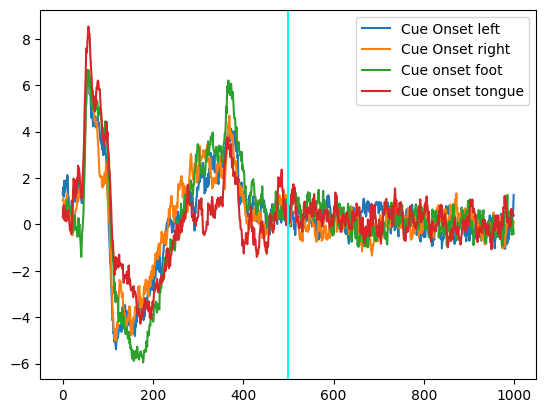

In [160]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# 2115 trials with each trial being a 22 x 1000 dimension data point
# Try to classify each movement by it's type/label (0, 1, 2, 3 - left, right, foot, tongue)
# Cue onset arm left - 0
# Cue onset arm right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

# Plotted for channel 8 of 22 channels
ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])




# Only using first 500 timesteps because from the chart we can see everything to the right
# of 500 looks like noise, while the left looks like better information
# Can also keep all 1000 if you want (optional preprocessing step)
# Too long of a time duration can be too much for RNN/LSTM, so it helps to reduce time duration

In [161]:

## Preprocessing the dataset
# ONLY TAKING FIRST 500 datapoints of the 1000
X_train_valid_prep = X_train_valid[:,:,0:500]
X_test_prep = X_test[:,:,0:500]




print(X_train_valid_prep.shape)
print(y_train_valid.shape)
print(X_test_prep.shape)
print(y_test.shape)



## Random splitting and reshaping the data

# 500 for validation, rest for training
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)










(2115, 22, 500)
(2115,)
(443, 22, 500)
(443,)
Shape of training set: (1615, 22, 500)
Shape of validation set: (500, 22, 500)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 500, 1)
Shape of validation set after adding width info: (500, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)
Shape of training set after dimension reshaping: (1615, 500, 1, 22)
Shape of validation set after dimension reshaping: (500, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)


In [162]:
# Building the CNN/LSTM Hybrid model using sequential class
hybrid_cnn_gru_model = Sequential()

# Conv. block 1
hybrid_cnn_gru_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', kernel_regularizer=L1L2(l1=0, l2=0.015), activation='elu', input_shape=(500,1,22)))
hybrid_cnn_gru_model.add(MaxPool2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.55))

# Conv. block 2
hybrid_cnn_gru_model.add(Conv2D(filters=50, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=0.015), padding='same', activation='elu'))
hybrid_cnn_gru_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.55))

# Conv. block 3
hybrid_cnn_gru_model.add(Conv2D(filters=100, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=0.015), padding='same', activation='elu'))
hybrid_cnn_gru_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.55))

# Conv. block 4
hybrid_cnn_gru_model.add(Conv2D(filters=200, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=0.015), padding='same', activation='elu'))
hybrid_cnn_gru_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.55))

# FC+GRU layers
hybrid_cnn_gru_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_gru_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_gru_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_gru_model.add(GRU(30, dropout=0.2, recurrent_dropout=0, input_shape=(40,1), kernel_regularizer=L1L2(l1=0, l2=0.015), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_gru_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_gru_model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_64 (Ba  (None, 167, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_64 (Dropout)        (None, 167, 1, 25)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 56, 1, 50)       

In [163]:
# Model parameters MODEL PARAMETERS
learning_rate = 0.00075
epochs = 150
hybrid_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay = 0.001)

In [ ]:
# Compiling the model COMPILING THE MODEL
hybrid_cnn_gru_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_gru_model_results = hybrid_cnn_gru_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/150
26/26 [==============================] - 2s 51ms/step - loss: 4.5793 - accuracy: 0.2576 - val_loss: 3.8828 - val_accuracy: 0.3420
Epoch 2/150
26/26 [==============================] - 1s 41ms/step - loss: 3.4540 - accuracy: 0.3331 - val_loss: 3.0485 - val_accuracy: 0.3320
Epoch 3/150
26/26 [==============================] - 1s 43ms/step - loss: 2.7945 - accuracy: 0.3839 - val_loss: 2.6017 - val_accuracy: 0.3280
Epoch 4/150
26/26 [==============================] - 1s 42ms/step - loss: 2.4062 - accuracy: 0.4186 - val_loss: 2.3654 - val_accuracy: 0.2980
Epoch 5/150
26/26 [==============================] - 1s 42ms/step - loss: 2.1926 - accuracy: 0.4155 - val_loss: 2.1921 - val_accuracy: 0.3360
Epoch 6/150
26/26 [==============================] - 1s 42ms/step - loss: 2.0435 - accuracy: 0.4235 - val_loss: 2.0518 - val_accuracy: 0.4060
Epoch 7/150
26/26 [==============================] - 1s 42ms/step - loss: 1.9109 - accuracy: 0.4681 - val_loss: 2.0220 - val_accuracy: 0.3400
Epoch 

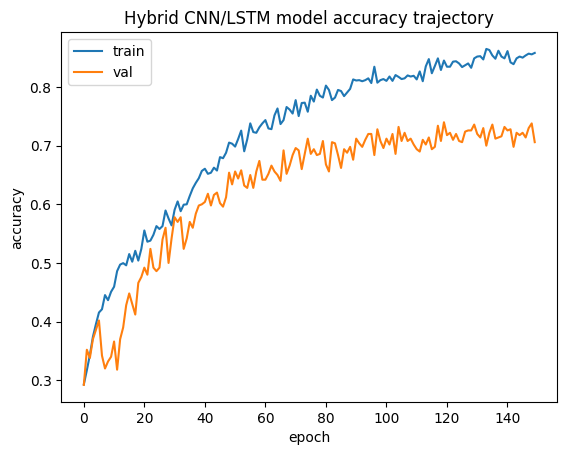

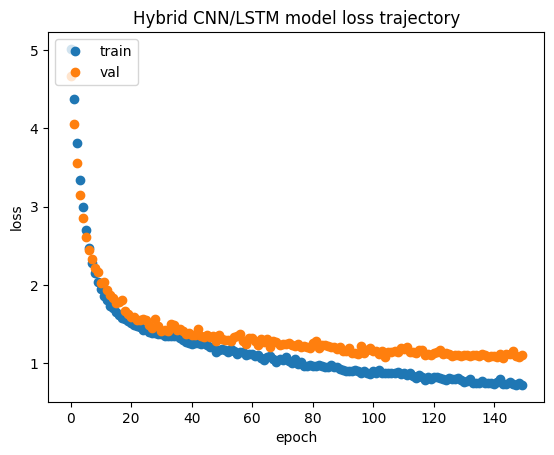

In [141]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_gru_model_results.history['accuracy'])
plt.plot(hybrid_cnn_gru_model_results.history['val_accuracy'])
plt.title('Hybrid CNN/GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_gru_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_gru_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN/GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [142]:
## Testing the basic CNN model - using the model from the last epoch (Must get 70% or higher for full credit)

hybrid_score = hybrid_cnn_gru_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hyrbid CNN/GRU model:',hybrid_score[1])

Test accuracy of the hyrbid CNN/GRU model: 0.7313769459724426


In [143]:
# Save Model
import pickle

filename = 'CNN_GRU_Hybrid.sav'
pickle.dump(hybrid_cnn_gru_model, open(filename, 'wb'))

In [153]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.evaluate(x_test, y_test, verbose=0)
print(result[1])

0.7313769459724426


This is a reasonabley well performing model, the validation accuracy (orange) is closely following the training accuracy (blue), so the model is not overfitting. Similar for the loss plot, the validation(orange) is following closely with the training loss (blue) and seems to be converging (going toward zero), may be better to train for more epochs to see further convergence.

U shaped curve for the loss means we are overfitting.